# Detection of Covid-19, Pneumonia and Normal using chest X-ray #

imutils = Imutils are a series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, and displaying Matplotlib images easier with OpenCV and both Python 2.7 and Python 3.
</br> ImageClassifier is a python package for creating Image classifiers with the help of CNNs.
</br>Image classification is the process of taking an input (like a picture) and outputting a class

In [29]:
!pip install imutils
!pip install image-classifiers==1.0.0b1

gc = Invoking the garbage collector manually during the execution of a program can be a good idea on how to handle memory being consumed by reference cycles.
</br>SGD = Stochastic Gradient Descent, it is an optimizer
</br>RMSprop stands for Root Mean Square Propagation. Widely-known gradient descent optimization algorithm for mini-batch learning of neural networks.
</br> 

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from datetime import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
import tensorflow as tf
import gc
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout,ZeroPadding2D, Add, GlobalAveragePooling2D, DepthwiseConv2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D, AveragePooling2D, Flatten, Dense, Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional


In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import precision_recall_curve,  plot_precision_recall_curve,  classification_report,  confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from imutils import paths

In [33]:
dataset_path = './out'
log_path = './logs'

bash allows ls and other codes
</br> rm -rf = can easily delete a folder
</br> mkdir -p command you can create sub-directories of a directory.

In [34]:
%%bash
rm -rf out
mkdir -p out
mkdir -p logs

In [35]:
ls ../input/covid19-pneumonia-normal-chest-xray-pa-dataset

covid/  normal/  pneumonia/


Creating a dataframe containing class and directory and updating the pneumonia/covid/normal and it's directory, appending index and sorting the index value in increasing order

In [36]:
df = pd.DataFrame(columns =['class', 'directory'])  
for path, names, filenames in os.walk('../input/covid19-pneumonia-normal-chest-xray-pa-dataset/normal'):
    for filename in filenames:
        df.loc[-1] = ["normal", ('normal/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index() 
for path, names, filenames in os.walk('../input/covid19-pneumonia-normal-chest-xray-pa-dataset/covid'):
    for filename in filenames:
        df.loc[-1] = ["covid", ('covid/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index() 
for path, names, filenames in os.walk('../input/covid19-pneumonia-normal-chest-xray-pa-dataset/pneumonia'):
    for filename in filenames:
        df.loc[-1] = ["pneumonia", ('pneumonia/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index() 

In [37]:
df

,class,directory
0,pneumonia,pneumonia/person1051_bacteria_2985.jpeg
1,pneumonia,pneumonia/person799_virus_1431.jpeg
2,pneumonia,pneumonia/person1541_virus_2681.jpeg
3,pneumonia,pneumonia/person652_bacteria_2544.jpeg
4,pneumonia,pneumonia/person1408_virus_2411.jpeg
...,...,...
6934,normal,normal/00000916_000.png
6935,normal,normal/00000315_004.png
6936,normal,normal/00000618_000.png
6937,normal,normal/NORMAL2-IM-0771-0001.jpeg


In [38]:
df_y = df['class']
df_x = df['directory']

In [39]:
df_x


0       pneumonia/person1051_bacteria_2985.jpeg
1           pneumonia/person799_virus_1431.jpeg
2          pneumonia/person1541_virus_2681.jpeg
3        pneumonia/person652_bacteria_2544.jpeg
4          pneumonia/person1408_virus_2411.jpeg
                         ...                   
6934                    normal/00000916_000.png
6935                    normal/00000315_004.png
6936                    normal/00000618_000.png
6937           normal/NORMAL2-IM-0771-0001.jpeg
6938                    normal/00000926_002.png
Name: directory, Length: 6939, dtype: object

In [40]:
df_y.value_counts()

pneumonia    2313
covid        2313
normal       2313
Name: class, dtype: int64

Splitting dataset into train, test and stratifying them in df_y(class) order

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, stratify= df_y, test_size=0.20, random_state=7)

X_train and X_test = image directory
</br> Y_test and Y_train = class label i.e covid, normal and pneumonia


In [42]:
Y_train.value_counts()

pneumonia    1851
covid        1850
normal       1850
Name: class, dtype: int64

below code shows a table showing the test class and directory
</br> axis = 1 represents along the columns
pd.concat means X_test and Y_test is concatenated

In [43]:
test = pd.concat([X_test, Y_test], axis = 1)
test.head()

,directory,class
3968,covid/COVID-19 (248).jpg,covid
6826,normal/00000237_000.png,normal
4626,normal/00000834_001.png,normal
4307,covid/COVID19(298).jpg,covid
2606,covid/COVID19(565).jpg,covid


a function copy_images is created which takes test images from the input path and is passed onto the output path and they are created into three subfolders normal,covid and Penumonia

In [44]:
def copy_images(df, directory):
    input_path = "../input/covid19-pneumonia-normal-chest-xray-pa-dataset"
    output_path = "out/" + directory 
    
    #if any old file exists in ouput path, it is removed
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
        
    #creating folder inside output path
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    #these three subfolders
    classes = ['normal', 'covid', 'pneumonia']
    for c in classes:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)
    
    #the original dataframe containing directory for each row, those directory are shifted from path_from to path_to
    #(that is from input directory to ouput directory)
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        path_to = "{}/{}".format(output_path, row['directory'])
        shutil.copy(path_from, path_to)
    

In [45]:
#copy_image function was created to move the test images from input to output directory
copy_images(test, 'test')


Those subfolders are created!

In [46]:
!ls ./out/test

covid  normal  pneumonia


In [47]:
print(len(os.listdir('./out/test/normal')))
print(len(os.listdir('./out/test/covid')))
print(len(os.listdir('./out/test/pneumonia')))

463
463
462


ImageDataGenerator - It lets you augment your images in real-time while your model is still training! You can apply any random transformations on each training image as it is passed to the model.
</br> Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1]. And the benefits are: Treat all images in the same manner: some images are high pixel range, some are low pixel range. ... Scaling every images to the same range [0,1] will make images contributes more evenly to the total loss.
</br> fill mode- When your image shift by some % there is some space left over and to fill that 

In [48]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

flow_from_directory - reads from that folder and various operations can be done to the images in that folder
</br> batch_size: No. of images to be yielded from the generator per batch.
</br>seed: Random seed for applying random image augmentation and shuffling the order of the image.
</br> for the test set, you should sample the images exactly once, no less or no more.

In [49]:
test_generator = test_datagen.flow_from_directory(
    directory=r"./out/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 1382 images belonging to 3 classes.


Naming each class their respective label

In [50]:
class_to_label_map = {'pneumonia' : 2, 'covid' : 1, 'normal' : 0}

# Creating the model

ResNet50 model is chosen for transfer learning which is stored in baseModel and layer.trainable = False means the layer is frozen so as to avoid destroying any of the information they contain during future training rounds. and finally the layer is flattened and is sent to 2 fully connected layers
optimizer used is RMSprop


</br> Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [51]:
def get_model():
    
    # Create Model..........................................
    
    # Input layer
    baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
        layer.trainable = False 
    x = baseModel.output

    
    # FC layer
    x = Flatten(name="flatten")(x)
    
    # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)


    # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    
    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    return model

Learning rate schedules = seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined scheduler. 
</br>StratifiedKFold =  is a variation of KFold. First, StratifiedKFold shuffles your data, after that splits the data into n_splits parts, it is just like Kfold where the entire data is split for 5 times doing the epoch(1-15), see the output for the next block code, running fold keeps iterating everytime epoch 1-15 is completed
</br> KFold is cross validation technique and Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. 
</br> log_dir is all about showing time it took to run 
</br< ModelCheckpoint callback is used ito connect with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved, and that is stored in variable called callback

In [52]:
from math import floor
from time import time
EPOCHS = 15
decay_rate = 0.95
decay_step = 1
learning_rate = 1e-4

def scheduler(lr):
    if epoch > 9:
        return lr
    else:
        global learning_rate
        learning_rate *=  decay_rate
        print('learning_rate: '+ str(learning_rate))
        return learning_rate
callback3 = LearningRateScheduler(scheduler)

skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [ModelCheckpoint(filepath='best_lstm_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True,save_weights_only=True),
             callback3, tensorboard_callback]

After creating the model, we need to train the model
for each epoch the datas are splitted by skf
</br>* enumerate() lets you write Pythonic for loops when you need a count and the value from an iterable. 
</br>* x_train, x_val, y_train, y_val is created
</br> train and val are concatenated so that they can be trained differently
and are copied to the ouput path
</br>* confusion matrix, classification report and history of time are saved into a csv file 
</br>* A Classification report is used to measure the quality of predictions
</br>* the augmented image of train and validation are passed into train_generator and val_generator and they are finally passed into model.fit_generator and here the model starts training, model.fit_generator() function first accepts a batch of the dataset, then performs backpropagation on it, and then updates the weights in our model.
</br>* like how fit generator is used for training the given models, prediction_generator is then used to predict the model
</br> classes of test generator is stored in testY

In [53]:
submission_predictions = []

for epoch, (train_index, val_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[val_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[val_index]
    
    print(y_train.value_counts())
    print(y_val.value_counts())

    train = pd.concat([x_train, y_train], axis=1)
    val = pd.concat([x_val, y_val], axis = 1)
    
    # copy the images according to the fold
    copy_images(train, 'train')
    copy_images(val, 'val')
    
    print('Running fold '+ str(epoch+1))
    
    # CREATE MODEL
    model = get_model()

    
    # Load Model Weights
    if epoch != 0:
        model.load_weights('best_model.h5') 
    
    train_generator = train_datagen.flow_from_directory(
        directory=r"./out/train/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    valid_generator = val_datagen.flow_from_directory(
        directory=r"./out/val/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    
    startTrain = time()
    history = model.fit_generator(
                generator=train_generator,
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                validation_data=valid_generator,
                validation_steps=valid_generator.n//valid_generator.batch_size,
                epochs=EPOCHS,
                callbacks=callbacks
    )
    print(time()-startTrain)
    
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = 'history.csv'
    

    
    test_generator.reset()
    startTest = time()
    predY=model.predict_generator(
            test_generator,
            steps=test_generator.n//test_generator.batch_size,
            verbose=1)
    print(time()-startTest)
    
    if epoch >= 1:
        submission_predictions.append(predY)
        
    testY = test_generator.classes
    confusion__matrix=confusion_matrix(testY, np.argmax(predY, axis = -1))
    cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4))
    print (cr)
    print(confusion__matrix)
    
    cm_df = pd.DataFrame(confusion__matrix)
    cr_df = pd.DataFrame(cr)
    with open(hist_csv_file, mode='a') as f:
        hist_df.to_csv(f)
        cm_df.to_csv(f)
        cr_df.to_csv(f)
     
    model.save('best_model.h5') 
    
    del history
    del model
    gc.collect()

normal       1851
pneumonia    1850
covid        1850
Name: class, dtype: int64
pneumonia    463
covid        463
normal       462
Name: class, dtype: int64
Running fold 1
Found 5524 images belonging to 3 classes.
Found 1378 images belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
learning_rate: 9.5e-05
345/345 [==============================] - 145s 412ms/step - loss: 1.5814 - accuracy: 0.6894 - val_loss: 17.8363 - val_accuracy: 0.3292

Epoch 00001: val_loss improved from inf to 17.83628, saving model to best_lstm_model.h5
Epoch 2/15
learning_rate: 9.025e-05
345/345 [==============================] - 140s 405ms/step - loss: 0.6333 - accuracy: 0.7984 - val_loss: 2.2442 - val_accuracy: 0.5109

Epoch 00002: val_loss improved from 17.83628 to 2.24419, saving model to best_lstm_model.h5
Epoch 3/15
learning_rate: 8.573749999999999e-05
345/345 [==============================] - 138s 399ms/step - loss: 0.5299 - accuracy: 0.8131 - val_loss: 1.8480 - val_accuracy: 0.5138

Epoch 00003: val_loss improved from 2.24419 to 1.84805, saving model to best_lstm_model.h5
Epoch 4/15
learning_rate: 8.145062499999998e-05
345/345 [==============================] - 142s 410ms/step - loss: 0.4082 - accuracy: 0.8586 - val_loss: 3.6419 - val_accuracy: 0.4048

Epoch 00004: val_l

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1382/1382 [==============================] - 32s 22ms/step
31.79291796684265
{'pneumonia': {'precision': 1.0, 'recall': 0.12910284463894967, 'f1-score': 0.22868217054263565, 'support': 457}, 'covid': {'precision': 0.861904761904762, 'recall': 0.7818574514038877, 'f1-score': 0.8199320498301247, 'support': 463}, 'normal': {'precision': 0.4850498338870432, 'recall': 0.948051948051948, 'f1-score': 0.6417582417582417, 'support': 462}, 'accuracy': 0.6215629522431259, 'macro avg': {'precision': 0.7823181985972684, 'recall': 0.6196707480315952, 'f1-score': 0.5634574873770007, 'support': 1382}, 'weighted avg': {'precision': 0.7815882257725895, 'recall': 0.6215629522431259, 'f1-score': 0.5648542682356295, 'support': 1382}}
[[ 59  34 364]
 [  0 362 101]
 [  0  24 438]]
covid        1851
pneumonia    1850
normal       1850
Name: class, dtype: int64
pneumonia    463
normal       463
covid        462
Name: class, dtype: int64
Running fold 2
Found 5520 images belonging to 3 classes.
Found 1382 images

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
learning_rate: 4.4012666865176535e-05
345/345 [==============================] - 149s 423ms/step - loss: 0.2672 - accuracy: 0.9102 - val_loss: 6.5997 - val_accuracy: 0.3314

Epoch 00001: val_loss did not improve from 0.46444
Epoch 2/15
learning_rate: 4.181203352191771e-05
345/345 [==============================] - 141s 409ms/step - loss: 0.2458 - accuracy: 0.9165 - val_loss: 1.8055 - val_accuracy: 0.5269

Epoch 00002: val_loss did not improve from 0.46444
Epoch 3/15
learning_rate: 3.972143184582182e-05
345/345 [==============================] - 140s 407ms/step - loss: 0.2252 - accuracy: 0.9225 - val_loss: 0.3426 - val_accuracy: 0.8706

Epoch 00003: val_loss improved from 0.46444 to 0.34263, saving model to best_lstm_model.h5
Epoch 4/15
learning_rate: 3.7735360253530726e-05
345/345 [==============================] - 139s 403ms/step - loss: 0.2321 - accuracy: 0.9190 - val_loss: 0.5260 - val_accuracy: 0.8401

Epoch 00004: val_loss did not improve from 0.34263
Epoch 5/15
learnin

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1382/1382 [==============================] - 31s 22ms/step
30.85074806213379
{'pneumonia': {'precision': 0.8761904761904762, 'recall': 0.8052516411378556, 'f1-score': 0.8392246294184721, 'support': 457}, 'covid': {'precision': 0.9671361502347418, 'recall': 0.4449244060475162, 'f1-score': 0.6094674556213018, 'support': 463}, 'normal': {'precision': 0.6048064085447263, 'recall': 0.9805194805194806, 'f1-score': 0.7481420313790257, 'support': 462}, 'accuracy': 0.7431259044862518, 'macro avg': {'precision': 0.8160443449899814, 'recall': 0.7435651759016174, 'f1-score': 0.7322780388062665, 'support': 1382}, 'weighted avg': {'precision': 0.815936067963384, 'recall': 0.7431259044862518, 'f1-score': 0.7318022475354663, 'support': 1382}}
[[368   1  88]
 [ 49 206 208]
 [  3   6 453]]
covid        1851
pneumonia    1850
normal       1850
Name: class, dtype: int64
pneumonia    463
normal       463
covid        462
Name: class, dtype: int64
Running fold 3
Found 5523 images belonging to 3 classes.
Fou

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
learning_rate: 2.039068257457904e-05
345/345 [==============================] - 150s 425ms/step - loss: 0.1730 - accuracy: 0.9373 - val_loss: 1.2680 - val_accuracy: 0.7529

Epoch 00001: val_loss did not improve from 0.24467
Epoch 2/15
learning_rate: 1.9371148445850086e-05
345/345 [==============================] - 141s 410ms/step - loss: 0.1706 - accuracy: 0.9426 - val_loss: 0.8203 - val_accuracy: 0.7435

Epoch 00002: val_loss did not improve from 0.24467
Epoch 3/15
learning_rate: 1.840259102355758e-05
345/345 [==============================] - 140s 404ms/step - loss: 0.1708 - accuracy: 0.9414 - val_loss: 0.3961 - val_accuracy: 0.8670

Epoch 00003: val_loss did not improve from 0.24467
Epoch 4/15
learning_rate: 1.74824614723797e-05
345/345 [==============================] - 139s 404ms/step - loss: 0.1692 - accuracy: 0.9374 - val_loss: 0.3903 - val_accuracy: 0.8692

Epoch 00004: val_loss did not improve from 0.24467
Epoch 5/15
learning_rate: 1.6608338398760715e-05
345/345 [==

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1382/1382 [==============================] - 30s 21ms/step
29.8532452583313
{'pneumonia': {'precision': 0.8788461538461538, 'recall': 1.0, 'f1-score': 0.9355168884339816, 'support': 457}, 'covid': {'precision': 0.9474885844748858, 'recall': 0.896328293736501, 'f1-score': 0.9211986681465039, 'support': 463}, 'normal': {'precision': 0.9882075471698113, 'recall': 0.9069264069264069, 'f1-score': 0.9458239277652369, 'support': 462}, 'accuracy': 0.9341534008683068, 'macro avg': {'precision': 0.9381807618302836, 'recall': 0.9344182335543026, 'f1-score': 0.9341798281152408, 'support': 1382}, 'weighted avg': {'precision': 0.9384021662170892, 'recall': 0.9341534008683068, 'f1-score': 0.9341655976799569, 'support': 1382}}
[[457   0   0]
 [ 43 415   5]
 [ 20  23 419]]
pneumonia    1851
covid        1850
normal       1850
Name: class, dtype: int64
normal       463
covid        463
pneumonia    462
Name: class, dtype: int64
Running fold 4
Found 5522 images belonging to 3 classes.
Found 1380 images b

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
learning_rate: 9.446824413773763e-06
345/345 [==============================] - 147s 415ms/step - loss: 0.1482 - accuracy: 0.9537 - val_loss: 0.1411 - val_accuracy: 0.9578

Epoch 00001: val_loss improved from 0.16528 to 0.14110, saving model to best_lstm_model.h5
Epoch 2/15
learning_rate: 8.974483193085074e-06
345/345 [==============================] - 139s 404ms/step - loss: 0.1363 - accuracy: 0.9533 - val_loss: 0.1767 - val_accuracy: 0.9201

Epoch 00002: val_loss did not improve from 0.14110
Epoch 3/15
learning_rate: 8.52575903343082e-06
345/345 [==============================] - 139s 403ms/step - loss: 0.1448 - accuracy: 0.9531 - val_loss: 0.4234 - val_accuracy: 0.8394

Epoch 00003: val_loss did not improve from 0.14110
Epoch 4/15
learning_rate: 8.09947108175928e-06
345/345 [==============================] - 140s 406ms/step - loss: 0.1640 - accuracy: 0.9431 - val_loss: 0.4103 - val_accuracy: 0.8488

Epoch 00004: val_loss did not improve from 0.14110
Epoch 5/15
learning_ra

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1382/1382 [==============================] - 30s 21ms/step
29.971147775650024
{'pneumonia': {'precision': 0.9825708061002179, 'recall': 0.986870897155361, 'f1-score': 0.9847161572052401, 'support': 457}, 'covid': {'precision': 0.9666666666666667, 'recall': 0.9395248380129589, 'f1-score': 0.9529025191675794, 'support': 463}, 'normal': {'precision': 0.9492600422832981, 'recall': 0.9718614718614719, 'f1-score': 0.960427807486631, 'support': 462}, 'accuracy': 0.9659913169319826, 'macro avg': {'precision': 0.9661658383500608, 'recall': 0.9660857356765972, 'f1-score': 0.9660154946198168, 'support': 1382}, 'weighted avg': {'precision': 0.966106848472757, 'recall': 0.9659913169319826, 'f1-score': 0.9659383482461704, 'support': 1382}}
[[451   3   3]
 [  7 435  21]
 [  1  12 449]]
pneumonia    1851
normal       1851
covid        1850
Name: class, dtype: int64
covid        463
pneumonia    462
normal       462
Name: class, dtype: int64
Running fold 5
Found 5519 images belonging to 3 classes.
Foun

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
learning_rate: 4.3766309037604346e-06
344/344 [==============================] - 146s 414ms/step - loss: 0.1197 - accuracy: 0.9596 - val_loss: 0.1155 - val_accuracy: 0.9557

Epoch 00001: val_loss did not improve from 0.10499
Epoch 2/15
learning_rate: 4.157799358572413e-06
344/344 [==============================] - 140s 408ms/step - loss: 0.1304 - accuracy: 0.9521 - val_loss: 0.1233 - val_accuracy: 0.9586

Epoch 00002: val_loss did not improve from 0.10499
Epoch 3/15
learning_rate: 3.949909390643792e-06
344/344 [==============================] - 140s 406ms/step - loss: 0.1173 - accuracy: 0.9599 - val_loss: 0.1295 - val_accuracy: 0.9542

Epoch 00003: val_loss did not improve from 0.10499
Epoch 4/15
learning_rate: 3.7524139211116024e-06
344/344 [==============================] - 141s 410ms/step - loss: 0.1216 - accuracy: 0.9604 - val_loss: 0.0931 - val_accuracy: 0.9688

Epoch 00004: val_loss improved from 0.10499 to 0.09306, saving model to best_lstm_model.h5
Epoch 5/15
learnin

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1382/1382 [==============================] - 30s 21ms/step
30.403269290924072
{'pneumonia': {'precision': 0.9977477477477478, 'recall': 0.9693654266958425, 'f1-score': 0.9833518312985573, 'support': 457}, 'covid': {'precision': 0.9108910891089109, 'recall': 0.9935205183585313, 'f1-score': 0.9504132231404958, 'support': 463}, 'normal': {'precision': 0.9907621247113164, 'recall': 0.9285714285714286, 'f1-score': 0.9586592178770951, 'support': 462}, 'accuracy': 0.9638205499276411, 'macro avg': {'precision': 0.966466987189325, 'recall': 0.9638191245419341, 'f1-score': 0.9641414241053826, 'support': 1382}, 'weighted avg': {'precision': 0.9663136010092436, 'recall': 0.9638205499276411, 'f1-score': 0.9640619883333634, 'support': 1382}}
[[443  12   2]
 [  1 460   2]
 [  0  33 429]]


from the predicted value it's average value is taken for each column

In [54]:
predY = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])

get_dummies() is used for data manipulation. It converts categorical data into dummy or indicator variables, similar to one hot encoding 
</br> * precision_recall_curve() is a sklearn function which creates the graph from the data 


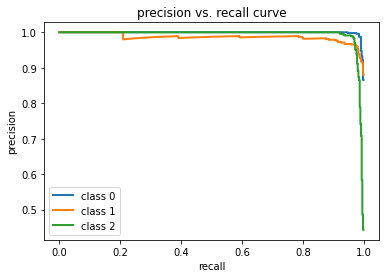

<Figure size 432x288 with 0 Axes>

In [55]:
precision = dict()
recall = dict()
hist_csv_file = 'history.csv'

y_test_dummies = pd.get_dummies(testY, drop_first=False).values
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i], predY[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()
plt.savefig('prc.png')

precision_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in precision.items() ]))
recall_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in recall.items() ]))
with open(hist_csv_file, mode='a') as f:
    precision_df.to_csv(f)
    recall_df.to_csv(f)

In [57]:
roc_auc_score(testY, predY, multi_class='ovo') #one-vs-one for multiclass

0.9964630417733339

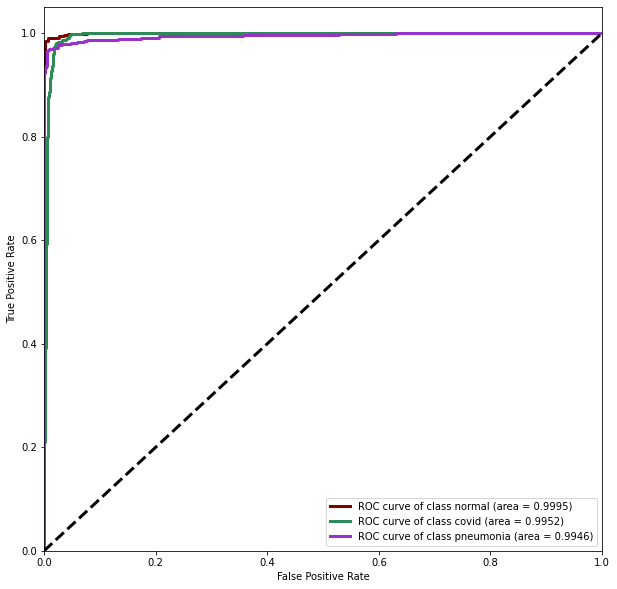

In [67]:

class_to_label = ['normal', 'covid', 'pneumonia']
import seaborn as sns
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(10, 10))
    lw = 3

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = ['maroon', 'seagreen', 'darkorchid']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_to_label[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc(testY, predY, n_classes=3, figsize=(10, 10))

In [68]:
conf_matrix = confusion_matrix(testY, np.argmax(predY, axis = -1))

In [79]:
print(cr_df)

            pneumonia       covid      normal  accuracy    macro avg  \
precision    0.997748    0.910891    0.990762  0.963821     0.966467   
recall       0.969365    0.993521    0.928571  0.963821     0.963819   
f1-score     0.983352    0.950413    0.958659  0.963821     0.964141   
support    457.000000  463.000000  462.000000  0.963821  1382.000000   

           weighted avg  
precision      0.966314  
recall         0.963821  
f1-score       0.964062  
support     1382.000000  


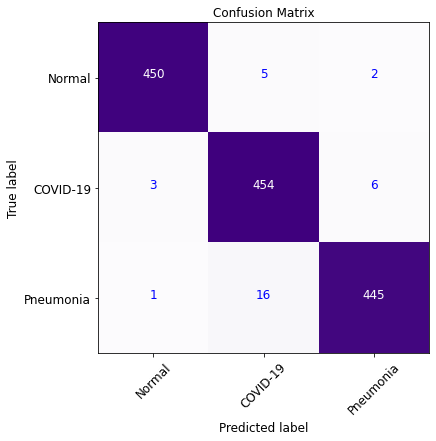

In [74]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'larger')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize = 'larger')
        plt.yticks(tick_marks, target_names, fontsize = 'larger')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "blue", fontsize = 'larger')
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "blue", fontsize = 'larger')


    plt.tight_layout()
    plt.ylabel('True label', fontsize = 'larger')
    plt.xlabel('Predicted label', fontsize = 'larger')

    plt.show()
    
plot_confusion_matrix(conf_matrix, 
                      normalize = False,
                      target_names = ['Normal', 'COVID-19', 'Pneumonia'],
                      title        = "Confusion Matrix")